<a href="https://colab.research.google.com/github/reckoning-machines/sec_text_nlp/blob/master/sec_nlp_beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://gist.github.com/Joshua1989/dc7e60aa487430ea704a8cb3f2c5d6a6

# we need to reinitialize local folders and data.

!mkdir sec_data_folder

In [2]:
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo
from colab_util import *
drive_handler = GoogleDriveHandler()

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [0]:
drive_handler.download('test_ticker_list.csv', target_path='test_ticker_list.csv')

In [4]:
import pandas as pd
df_tickers = pd.read_csv('test_ticker_list.csv')

for i, row in df_tickers.iterrows():
  str_ticker = row['Symbol']
  
  print('working for:'+str_ticker+"...")

  str_to_file = 'sec_data_folder/'+str_ticker+'.csv'
  str_from_file = '/sec_data_folder/'+str_ticker+'.csv'
  drive_handler.download(str_to_file, target_path=str_from_file)

working for:GOOG...
working for:FB...
working for:AMZN...
working for:HD...
working for:WMT...
working for:PG...
working for:XOM...
working for:CVX...
working for:JPM...
working for:BAC...
working for:JNJ...
working for:UNH...
working for:LMT...
working for:UNP...
working for:MSFT...
working for:AAPL...
working for:LIN...
working for:ECL...
working for:AMT...
working for:CCI...
working for:NEE...
working for:D...


In [5]:

#import academic standard NLP library nltk.  this will be our baseline.
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

#replace with your own list of words ... like covid or delay or cancel (it lowercases automatically)
FIND_WORDS = ['covid',
              'guidance',
              'outlook']

def check_if_list_found_in_text(text, words=[], return_offset=False, lower_text=True):
    result = []
    text = (
        " "
        + text.replace("_", " ")
        .replace("-", " ")
        .replace(",", " ")
        .replace(";", " ")
        .replace('"', " ")
        .replace(":", " ")
        .replace(".", " ")
        + " "
    )
    if lower_text:
        text = text.lower()
    for word in words:
        word = (
            " "
            + word.replace("_", " ")
            .replace("-", " ")
            .replace(",", " ")
            .replace(";", " ")
            .replace('"', " ")
            .replace(":", " ")
            .replace(".", " ")
            + " "
        )
        if lower_text:
            word = word.lower()
        if word in text:
            if return_offset:
                offset = text.find(word)
                # offset = offset if not offset else offset-1
                result.append(offset)
            else:
                result.append(word.strip())
    return result

def filter_stopwords(sent):
    stop_words = set(stopwords.words('english'))   
    word_tokens = word_tokenize(sent)   
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

def df_from_text(text):
    sentence_list = tokenize.sent_tokenize(text)
    sentence_list
    sid = SentimentIntensityAnalyzer()
    list_df = []
    for sentence in sentence_list:
        sentence = filter_stopwords(sentence)
        list_found = check_if_list_found_in_text(sentence,FIND_WORDS)
        num_found = len(list_found)
        ss = sid.polarity_scores(sentence)
        df = pd.DataFrame.from_dict(ss,orient = "index").T
        df['text'] = sentence
        df['keywords_found'] = num_found 
        list_df.append(df)
    return pd.concat(list_df)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [6]:
#read and process data into a single dataset.  add ticker along the way.
master_list_df = []
list_tickers = df_tickers['Symbol']
for ticker in list_tickers:
  
  df_text = pd.read_csv("sec_data_folder/"+ticker+".csv") 
  df_text['ticker'] = ticker
  
  print("working on..."+ticker)
  
  df_discussion = df_text[df_text['section']=='discussion']

  list_df = []
  for i,row in df_discussion.iterrows(): #this is greedy and should be vectorized with apply once debugged
    df = df_from_text(row['text']) 
    df['id'] = i 
    df['period_date'] = row['period_date']
    df['type'] = row['type']
    df['section'] = row['section']
    list_df.append(df)
  
  df_sentence_text_scores = pd.concat(list_df)
  df_sentence_text_scores = df_sentence_text_scores.groupby(['period_date','type']).sum().reset_index()
  df_sentence_text_scores['ticker'] = ticker
  df_sentence_text_scores.drop(['id','keywords_found'],axis = 1)
  
  #scaled scores and differences
  df_sentence_text_scores['compound_baseline'] = df_sentence_text_scores['compound'] / df_sentence_text_scores['compound'].mean()
  df_sentence_text_scores['neg_baseline'] = df_sentence_text_scores['neg'] / df_sentence_text_scores['neg'].mean()
  df_sentence_text_scores['pos_baseline'] = df_sentence_text_scores['pos'] / df_sentence_text_scores['pos'].mean()
  df_sentence_text_scores['compound_bdiff'] = df_sentence_text_scores['compound_baseline'].diff() 
  df_sentence_text_scores['neg_bdiff'] = df_sentence_text_scores['neg_baseline'].diff() 
  df_sentence_text_scores['pos_bdiff'] = df_sentence_text_scores['pos_baseline'].diff() 
  df_sentence_text_scores['compound_zscore'] = (df_sentence_text_scores['compound'] - df_sentence_text_scores['compound'].mean())/df['compound'].std(ddof=0)

  master_list_df.append(df_sentence_text_scores)

df_data = pd.concat(master_list_df)


working on...GOOG
working on...FB
working on...AMZN
working on...HD
working on...WMT
working on...PG
working on...XOM
working on...CVX
working on...JPM
working on...BAC
working on...JNJ
working on...UNH
working on...LMT
working on...UNP
working on...MSFT
working on...AAPL
working on...LIN
working on...ECL
working on...AMT
working on...CCI
working on...NEE
working on...D


In [7]:
df_data.to_csv("df_data.csv")
drive_handler.upload('df_data.csv', parent_path='sec_data_folder',overwrite=False)

'1XbxYRptUss3xKnHmE4lIzXDiP3kHQC6f'

In [26]:
df = df_data[['period_date','ticker','compound_baseline']]
df['quarter_end'] = pd.to_datetime(df['period_date'])
df['quarter_end'] = df['quarter_end'].dt.to_period('quarter_end').dt.end_time
df['quarter_end'] = df['quarter_end'].dt.date
import numpy as np
df_data_pivot = pd.pivot_table(df, values='compound_baseline', index=['q'],
                    columns=['ticker'], aggfunc=np.sum, fill_value=0).reset_index()

df_data_pivot.to_csv("df_data_pivot.csv")
drive_handler.upload('df_data_pivot.csv', parent_path='sec_data_folder',overwrite=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/di

'1D5G9C1Cxhxk_4nnpRbxKc6vMEcJuAfeO'

In [8]:
df_data.head(6)

,period_date,type,neg,neu,pos,compound,keywords_found,id,ticker,compound_baseline,neg_baseline,pos_baseline,compound_bdiff,neg_bdiff,pos_bdiff,compound_zscore
0,2018-12-31T00:00:00Z,10-K,11.700,368.919,51.383,90.1384,0,563064,GOOG,1.245985,1.638962,1.384470,NaN,NaN,NaN,99.164243
1,2019-03-31T00:00:00Z,10-Q,4.263,247.329,27.409,58.0661,0,296014,GOOG,0.802649,0.597170,0.738512,-0.443336,-1.041791,-0.645959,-79.558362
2,2019-06-30T00:00:00Z,10-Q,4.271,262.147,31.584,68.9674,0,252767,GOOG,0.953338,0.598291,0.851003,0.150689,0.001121,0.112492,-18.810965
3,2019-09-30T00:00:00Z,10-Q,4.629,263.763,30.610,67.5397,0,188918,GOOG,0.933603,0.648440,0.824760,-0.019735,0.050149,-0.026244,-26.766811
4,2019-12-31T00:00:00Z,10-K,12.058,374.402,52.545,87.2673,0,167825,GOOG,1.206298,1.689111,1.415779,0.272695,1.040671,0.591020,83.165064
5,2020-03-31T00:00:00Z,10-Q,5.911,297.938,29.152,62.0796,19,40131,GOOG,0.858128,0.828026,0.785475,-0.348170,-0.861085,-0.630304,-57.193169


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


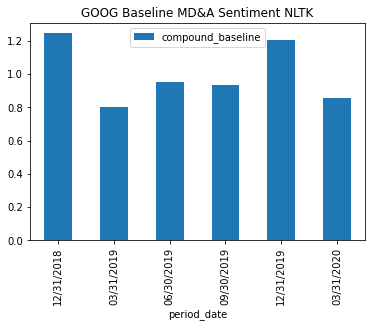

In [9]:
df_grouped = df_data[df_data['ticker'] == 'GOOG']
df_grouped['period_date'] = pd.to_datetime(df_grouped['period_date'])
df_grouped['period_date'] = df_grouped['period_date'].dt.strftime('%m/%d/%Y')
df_grouped.plot(x='period_date',y='compound_baseline',kind = 'bar',title = 'GOOG Baseline MD&A Sentiment NLTK')

#to do:
#debug why 6 periods
#delta baseline vs following 5 day alpha in stock
#ARIMA model fit (or sum of squares for easy explanation).
#the NLTK implementation is the base standard of comparison

#pytorch transformers sentiment analysis - language model
#as above, delta baseline vs alpha
#compare w NLTK ARIMA/linear regression fit.
